In [10]:
import pyswarms as ps
from pyswarms.utils.plotters import (plot_cost_history)



In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn import preprocessing 
from scipy.io import arff
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_error


In [13]:
data = arff.loadarff("./dataset/Medicaldataset.arff")

In [14]:
df = pd.DataFrame(data[0])

df.head()

,age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
0,64.0,1.0,66.0,160.0,83.0,160.0,1.80,0.012,b'negative'
1,21.0,1.0,94.0,98.0,46.0,296.0,6.75,1.060,b'positive'
2,55.0,1.0,64.0,160.0,77.0,270.0,1.99,0.003,b'negative'
3,64.0,1.0,70.0,120.0,55.0,270.0,13.87,0.122,b'positive'
4,55.0,1.0,64.0,112.0,65.0,300.0,1.08,0.003,b'negative'


In [15]:
X = df.iloc[:,df.columns !='class'].to_numpy() #select all features except for class
X = preprocessing.normalize(X, axis=1) #normalizing the features

y = df['class'].str.decode('utf-8') #transform target to 0 and 1
mapping = {'negative': 0, 'positive': 1}
y = y.replace(mapping).to_numpy()


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

In [17]:
y_train = np.array(y_train) #make it numpy array for math operations
type(y_train)

numpy.ndarray

In [18]:
#set up NN architecture
n_inputs = 8 #input layer
n_hidden = 20 #hidden layer
n_classes = 3 #output layer

num_samples = 883 #number of samples

In [19]:
def logits_function(p):
    """ Calculate roll-back the weights and biases

    Inputs
    ------
    p: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    numpy.ndarray of logits for layer 2

    """
    # Roll-back the weights and biases
    W1 = p[0:160].reshape((n_inputs,n_hidden))
    b1 = p[160:180].reshape((n_hidden,))
    W2 = p[180:240].reshape((n_hidden,n_classes))
    b2 = p[240:243].reshape((n_classes,))

    # Perform forward propagation
    z1 = X_train.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)           # Activation in Layer 1
    logits = a1.dot(W2) + b2   # Pre-activation in Layer 2
    return logits              # Logits for Layer 2

In [20]:
# Forward propagation
def forward_prop(params):
    """Forward propagation as objective function

    This computes for the forward propagation of the neural network, as
    well as the loss.

    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    float
        The computed negative log-likelihood loss given the parameters
    """
    logits = logits_function(params)
   
    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Compute for the negative log likelihood

    corect_logprobs = -np.log(probs[range(num_samples), y_train])
    
    loss = np.sum(corect_logprobs) / num_samples
    return loss


In [21]:
def f(x):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)] #for loop to calculate loss for each particle
    return np.array(j)

In [22]:
%%time
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=2000)

2023-11-18 21:38:15,588 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/2000, best_cost=0.674

pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=0.125
2023-11-18 21:39:05,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.12468385726278693, best pos: [ 6.42559590e-01 -4.37369292e-01 -5.20843664e-02  7.56503788e-01
  7.31953904e-02  8.01340685e-01 -4.71148880e-02  5.26053032e-01
  1.32702204e+00  2.81577535e-01 -3.08345448e+00  5.91526050e-01
  1.38510994e+00  5.84288081e-01  2.17325003e+00  1.38571918e+00
  2.31260857e+00  7.13316491e-01 -4.03126967e-02  6.29864954e-01
 -5.99205715e-01 -1.81521722e+00  1.31078396e-01 -8.50276426e-01
  4.13520616e-01  1.19468337e+00  1.66286337e-02  9.27139841e-01
  1.03793917e+00  3.86494997e-01  1.28344835e+00  9.42712230e-01
 -8.76371307e-01 -4.28219006e-01  9.31448147e-01  4.96018866e-02
  6.93100838e-01 -4.82984087e-01 -2.92438030e-02 -1.36468390e+00
  9.90972715e-01  2.48751539e-01 -5.31173727e-02  7.98996217e-01
  1.68278807e+00  6.07641678e-01  1.53015614e+00  4.27848279e-01
  1.66046618e+00  1

CPU times: total: 16.1 s
Wall time: 49.9 s


In [23]:
def predict(pos):
    """
    Use the trained weights to perform class predictions.

    Inputs
    ------
    pos: numpy.ndarray
        Position matrix found by the swarm. Will be rolled
        into weights and biases.
    """
    logits = logits_function(pos)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

In [24]:
(predict(pos) == y_train).mean()

0.9524348810872028

In [25]:
#visualization
#import modules

#import additional libraries
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)


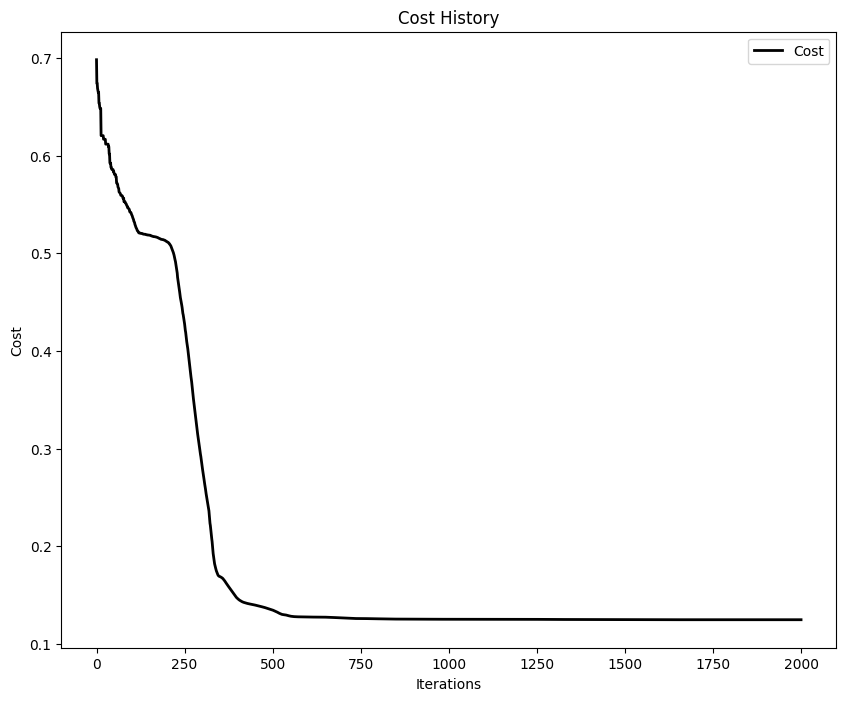

In [26]:
plot_cost_history(cost_history= optimizer.cost_history)
plt.show()

In [27]:
#animated swarm
from pyswarms.utils.plotters.formatters import Mesher
from pyswarms.utils.functions import single_obj as fx


In [28]:
# Initialize mesher with sphere function
m = Mesher(func=fx.sphere)
                     
#set the position of the particles swarm in one of the dimension 
position = np.array(optimizer.pos_history)
position = position[:,:, 220:222]

2023-11-18 21:39:07,746 - matplotlib.animation - WARNING - MovieWriter ffmpeg unavailable; using Pillow instead.
2023-11-18 21:39:07,746 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


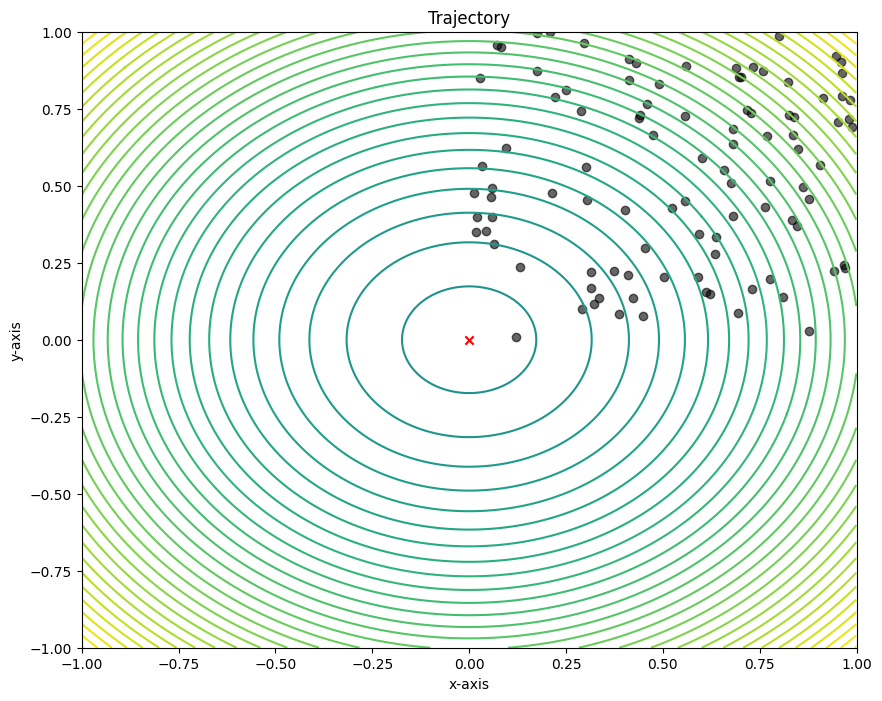

In [29]:
#Plot 2D Contour
#Make animation
anim = plot_contour(pos_history=position,
                            mesher=m,
                            mark=(0,0)) #red cross in the middle  

anim.save('2d.gif')                          

2023-11-18 21:42:20,050 - matplotlib.animation - WARNING - MovieWriter ffmpeg unavailable; using Pillow instead.
2023-11-18 21:42:20,053 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


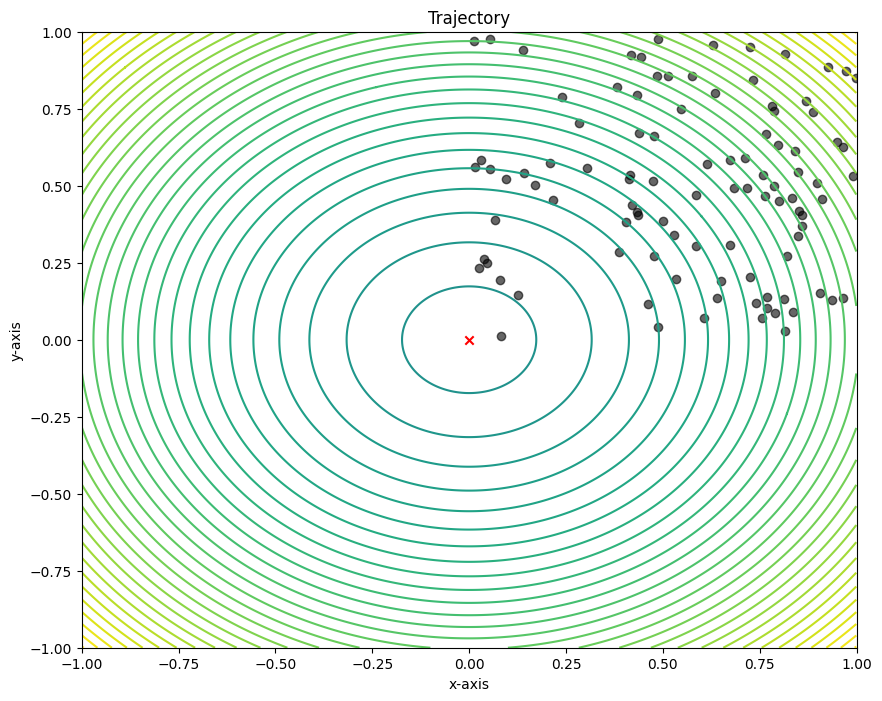

In [30]:
#plot 2D contour with optimizer based on velocity history
position = np.array(optimizer.velocity_history)
position = position[:,:, 220:222]
anim = plot_contour(pos_history=position,
                            mesher=m,
                            mark=(0,0)) #red cross in the middle  

anim.save('2d_velocity.gif')  